# Generative Adversarial Networks

This is an implementation of a [Generative Adversarial Network (GAN)](https://arxiv.org/abs/1406.2661). These networks are based on the [Deep Convolutional GAN](https://arxiv.org/abs/1511.06434) architecture.

This notebook demonstrates the ability of GANs to generate images. We first run through the fundamental idea of a GAN, and then implement code for producing images. For clarity in this discussion, the starting set of images will be called the 'original images.' The images produced by the GAN will be called the 'generated images.'

## Generative Adversarial Network
### Basic Idea
GANs are comprised of two competing weighted networks: the generator and the discriminator. The generator produces examples, and the discriminator labels images as either generated or original. In the training phase, the generator is improved so that generated examples are more likely to be labeled as original by the discriminator. In turn, the discriminator is improved to be able to more accurately label generated and original examples. This is why these are adversarial networks: they have competing goals.

### Training Process
The process of training the two networks is typically done in the following two steps:
1. We pass generated images along with original images to the discriminator.
1. The discriminator assigns a probability that the image is generated or real. If the discriminator assigns a score of $0$, then the image is considered generated. If the discriminator assigns a score of $1$, then the image is considered original. Scores that are between these two reflect uncertainty about the source.
1. We score the *discriminator* based on how accurate the probabilities assigned were. We update the discriminator to improve it's ability to assign the correct probability.

We then train the generator on a competing goal:
1. We pass generated images to the discriminator.
1. The discriminator assigns a probability that the image is generated or real.
1. We score the *generator* based on how convincing the generated images were. We update the generator so that generated images are more likely to be labeled as original by the discriminator.

### Score Function
Mathematically, if $D$ is the discriminator and $G$ is the generator, then we can characterize this as a two-player minimax game (i.e. a game where we are trying to minimize the maximum expected loss) with the expected value function

$$V(D, G) = \mathbb{E}_{x\sim p_{\text{data}}}[\log D(x)]+\mathbb{E}_{z\sim p_{d}}[\log (1 - D(G(z)))].$$
In this equation, the first term scores the original images, while the second term scores the generated images. (Quick math breakdown: $\mathbb{E}$ means 'expected value,' or what we expect to get based on the distributions. $x\sim p_{\text{data}}$ is shorthand for 'x drawn from the distribution of data,' which can be thought of 'x is an original image.' Similarly, $z\sim p_{d}$ is shorthand for 'z drawn from random noise,' with $G(z)$ being a generated image from random noise.)

When we update the discriminator, we update with the intent of increasing the value function. This is accomplished by updating $D$ so that $D(x)$ is closer to $1$ (which increases the first term), and $D(G(z))$ is closer to $0$ (which increases the second term). That is, improving the score of the discriminator on this value function improves the ability of the discriminator to tell apart generated and original images.

In contrast, we update $G$ with the intent of lowering the value function. As the first term does not depend on $G$, the updates only effect the second term. In this situation, $G$ is updated so that $D(G(z))$ is pushed closer to $1$.

It's worth noting that there is a critical issue with this function. In particular, if the discriminator is able to tell apart images with a high degree of accuracy early in training, then $\log(1-D(G(z)))$ will not be able to provide sufficient gradients for training $G$. The reason is due to the saturation, as $\log(1-D(G(z))$ has vanishing gradients if $D(G(z))$ is very close to 1. Due to this, it is suggested to use a different function for updating the generator.

### Alternate Generator Score Function
To alleviate the problem of vanishing gradients, it is recommended to update $G$ using the value function

$$\mathbb{E}_{z\sim p_{d}}[\log D(G(z))].$$

By maximizing this score function, we also minimize the second term of the original score function. Moreover, the gradients are suitable for learning even when the generator is low quality.

## Deep Convolutional GAN
The Deep Convolutional GAN (DCGAN) is a specific architecture architecture for image GANs introduced [here](https://arxiv.org/abs/1511.06434) that is known to be effective. It takes advantage of strided convolutions and convolution transposes to learn downsampling and upsampling, and makes a number of recommendations to encourage stability. The architecture below is based on the lua/torch implementation [here](https://github.com/soumith/dcgan.torch). To quote the suggestions from the article (p. 3):

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

In order to use a Tanh activation function, we first shift the images to have a range of $[-1, 1]$, instead of $[0, 1]$. For optimization, they use Adam with a learning rate of $0.0002$ and hyperparameter $\beta_1 = 0.5$.

In [1]:
#Import libraries
import matplotlib.pyplot as plt
import os
import torch as t
import torch.nn as nn
import torchvision.datasets as datasets

from numpy import median
from random import sample
from torchvision.transforms import Compose, Pad, ToTensor
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid, save_image
from torch.nn import BCEWithLogitsLoss

print('Current working directory: ', os.getcwd())
try:
    os.mkdir(os.getcwd()+'/samples')
except FileExistsError:
    pass

Current working directory:  D:\Code\PyTorch_NBs


## Dataset
To test the GAN architecture, we will use the Fashion MNIST dataset with randomized color.

Something that has a large impact on the performance is the image shape and convolution kernel shape. To avoid any issues, we pad the image to be $32 \times 32$ and use a convolution kernel that shrinks the image by half.

In [2]:
def make_sampler(batch_size, device='cpu', train=True):
    '''
    Create a random batch sampler. This function creates an (infinite) iterator, 
    which can be used to get new samples using the next command. i.e.
    
    sampler = make_sampler(64, 'cuda')
    sample = next(sampler)
    
    :param batch_size: (int) Number of examples to return
    :param device: (str) Device to move examples to.
    :return: iterator
    '''
    mnist_transforms = Compose([Pad(2), ToTensor()])
    shift = lambda image : (image - .5) * 2
    mnist_set = datasets.FashionMNIST(root='./data/', train=train, download=True, transform=mnist_transforms)
    color_tensor = t.zeros((batch_size, 3, 1, 1), device=device)
    while True:
        mnist_idx = sample(range(len(mnist_set)), batch_size)
        mnist_tensor = t.cat([mnist_set[idx][0].unsqueeze(0) for idx in mnist_idx], 0).to(device)
        color_tensor.uniform_(0.2, 1)
        yield shift(mnist_tensor*color_tensor)

#Pick batch size
batch_size = 64
#set device
device = 'cuda' if t.cuda.is_available() else 'cpu'

#Set up batch loader
training_sample = make_sampler(batch_size, device)

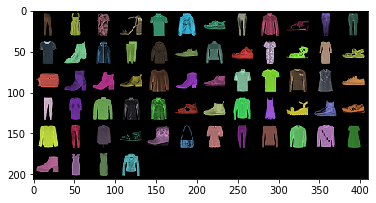

In [3]:
sample_image = to_pil_image(make_grid((next(training_sample)+1)/2, 12).cpu())
plt.imshow(sample_image)

In [4]:
def init_weights(module):
    '''
    Initializes weights as in lua DCGAN.
    '''
    if type(module) in [nn.Conv2d, nn.ConvTranspose2d]:
        nn.init.normal_(module.weight, 0, 0.02)
    elif type(module) == nn.BatchNorm2d:
        nn.init.normal_(module.weight, 1, 0.02)
        
def print_update(epoch, dis_score, gen_score):
    print('\rEpoch {0} - originals: {1:.4f} - generated: {2:.4f}'.format(epoch, dis_score, gen_score), end='')

In [5]:
#Create deep convolution discriminator
#Note: The sigmoid is not included in the sequential, so that we can use
#logits instead. 
class Discriminator(nn.Module):
    def __init__(self, nc, z_size, channel_factor):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Conv2d(nc, channel_factor, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channel_factor, 2*channel_factor, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*channel_factor),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2*channel_factor, 4*channel_factor, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*channel_factor),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4*channel_factor, 1, 4, 2, bias=False),
            nn.Flatten()
        )
        self.D.apply(init_weights)

    def forward(self, input):
        return t.sigmoid(self.D(input))
    
    def loss(self, input, originals=True):
        logits = self.D(input)
        if originals:
            category = t.ones_like(logits)
        else:
            category = t.zeros_like(logits)
        return nn.functional.binary_cross_entropy_with_logits(logits, category)

#Create deep convolution generator
class Generator(nn.Module):
    def __init__(self, nc, z_size, channel_factorz):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_size, 4*channel_factor, 4, 2, bias=False),
            nn.BatchNorm2d(4*channel_factor),
            nn.ReLU(),
            nn.ConvTranspose2d(4*channel_factor, 2*channel_factor, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*channel_factor),
            nn.ReLU(),
            nn.ConvTranspose2d(2*channel_factor, channel_factor, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_factor),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_factor, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.G.apply(init_weights)
        #Add useful attribute
        self.z_size = z_size
    
    def forward(self, input):
        return self.G(input)
    
    def generate(self, size, device='cpu'):
        z = t.randn((size, self.z_size, 1, 1), device=device)
        return self.forward(z)

In [6]:
#Set hyperparameters for network size
z_size = 100
nc = 3
channel_factor = 32

#Make networks
discriminator = Discriminator(nc, z_size, channel_factor)
generator = Generator(nc, z_size, channel_factor)

#Move to proper device
discriminator.to(device)
generator.to(device)

#Create optimizers
lr = 0.0002
betas = (.5, .999)
dis_optim = t.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
gen_optim = t.optim.Adam(generator.parameters(), lr=lr, betas=betas)

In [7]:
def train_GAN(
    generator,
    discriminator,
    gen_optim,
    dis_optim,
    epochs=20,
    update_steps=50,
    dis_updates_per_gen=1, 
    batch_size=64,
    testing_steps=5,
    save_size=6,
    name='GAN'
):
    '''
    Trains generative adversarial networks. Requires the generator to have a
    generate function (for producing examples), and the discriminator to have
    a loss function (for scoring examples).
    '''
    #Fix a z variable for watching image generation change over time
    fixed_z = t.randn((save_size**2, z_size, 1, 1), device=device)

    #Make sampler
    training_sample = make_sampler(batch_size, device, True)
    testing_sample = make_sampler(batch_size, device, False)
    
    #Record history
    gen_scores = []
    dis_scores = []
    
    #Set save directory
    directory = os.getcwd() + '/samples/{0}'.format(name)
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
    for epoch in range(epochs):
        for _ in range(update_steps):
            for _ in range(dis_updates_per_gen):
                #Clear gradients
                dis_optim.zero_grad()
                #Get original images
                original = next(training_sample)
                #Generate images for training discriminator - they do not need gradients
                with t.no_grad():
                    generated = generator.generate(batch_size, device)

                #Score images and update discriminator
                original_scores = discriminator.loss(original, originals=True)
                generated_scores = discriminator.loss(generated, originals=False)
                dis_score = original_scores+generated_scores
                dis_score.backward()
                dis_optim.step()

            #Clear generator gradients
            gen_optim.zero_grad()
            #Generate batch
            generated = generator.generate(batch_size, device)
            #Aim to decrease loss of scoring them as original
            gen_score = discriminator.loss(generated, originals=True)
            gen_score.backward()
            gen_optim.step()
            
        #Check progress
        gen_score, dis_score = validation_testing(generator, discriminator, testing_sample, testing_steps)
        gen_scores.append(gen_score)
        dis_scores.append(dis_score)
        print_update(epoch, dis_score, gen_score)
        
        #Save images generated from fixed z
        generated = (generator(fixed_z)+1)/2
        
        file_name = directory + '/epoch-{0}.png'.format(epoch)
        save_image(generated, file_name, nrow=save_size)

        generator.train()
        discriminator.train()
    return gen_scores, dis_scores

def validation_testing(generator, discriminator, sampler, testing_steps):
    '''
    Perform validation testing for the generator and discriminator. In particular, we
    are seeing how the discriminator categorizes real images vs generated images.
    
    We do not optimize in this function call, and so both networks are static.
    '''
    #Put in evaluation mode
    generator.eval()
    discriminator.eval()
    dis_score = 0.
    gen_score = 0.
    #Disable gradients
    with t.no_grad():
        for _ in range(testing_steps):
            #Get the score of the discriminator on original images
            batch = next(sampler)
            dis_score += float(t.mean(discriminator(batch)))
            #Get the score of the discriminator on generated images
            generated = generator.generate(batch.shape[0], device)
            gen_score += float(t.mean(discriminator(generated)))
    #Average
    dis_score = dis_score/testing_steps
    gen_score = gen_score/testing_steps

    #Return to training mode
    generator.train()
    discriminator.train()
    
    return gen_score, dis_score

In [8]:
#Set how many times to update the discriminator before updating the generator
dis_updates_per_gen = 1

#Set how frequently to validate examples
update_steps = 100
#Set how many batches to use for validation. More gives a better estimate, but takes longer.
validation_steps = 5

#Number of validations to perform. We train over update_steps*epochs iterations.
epochs = 50

#Pick a size for the saved images
save_size = 6

gan_scores = train_GAN(
    generator,
    discriminator,
    gen_optim,
    dis_optim,
    epochs,
    update_steps,
    dis_updates_per_gen,
    validation_steps,
    batch_size,
    save_size,
    'GAN'
)

Epoch 49 - originals: 0.6857 - generated: 0.5253

### Validation
Below we have a graph of the average category assigned to examples by the discriminator. The discriminator is training to assign real images a $1$ and fake images a $0$. The generator is training to have generated images assigned a $1$ by the discriminator. Below, we see how this evolves over time.

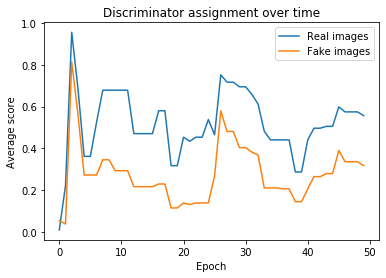

In [9]:
def plot_validation(scores, title, filter_size=3):
    plt.plot(median_filter(scores[1], filter_size), label='Real images')
    plt.plot(median_filter(scores[0], filter_size), label='Fake images')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Average score')
    plt.show()
    
def median_filter(x, kernel_size=3):
    xmed = [median(x[k:k+kernel_size]) for k in range(len(x)-kernel_size)]
    xnew = x[:kernel_size]+xmed
    return xnew
    
plot_validation(gan_scores, 'Discriminator assignment over time', 5)

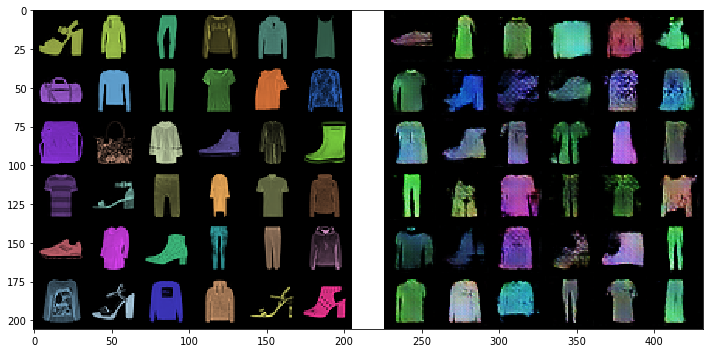

In [10]:
def descale(images):
    return (images+1)/2

def generate_sample(generator, sampler, width, device='cpu', buffer=20):
    #Get a sample of original images for comparison
    image_sample = next(sampler)
    sample_grid = make_grid(image_sample, width, pad_value=-1).cpu()
    #Get a sample of generated images
    generated = generator.generate(width**2, device)
    generated = make_grid(generated, width, pad_value=-1).cpu()
    #make a buffer
    buffer = t.ones((3, sample_grid.shape[1], buffer))
    
    image = t.cat([sample_grid, buffer, generated], 2)
    #Same as before - fix range and display
    
    return descale(image)

sampler = make_sampler(64)
image = generate_sample(generator, sampler, 8, device)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(to_pil_image(image))

## WGAN

TODO: Explain properly.

The Wasserstein GAN is a variant of the GAN that aims to alleviate some of the difficulties of training GANs by changing the training objective. In particular, we measure the difference between the two distributions in a different way. For this method of training a GAN, the discriminator must satisfy a Lipschitz condition. The original paper recommended doing this by clamping. However, we do this here using the `spectral_norm` function.

In [16]:
from torch.nn.utils import spectral_norm
class WDiscriminator(Discriminator):
    def __init__(self, nc, z_size, channel_factor):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            spectral_norm(nn.Conv2d(nc, channel_factor, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(channel_factor, 2*channel_factor, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(2*channel_factor, 4*channel_factor, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(4*channel_factor, 1, 4, 2, bias=False)),
            nn.Flatten()
        )
        self.D.apply(init_weights)
        
    def forward(self, input):
        #Remove sigmoid from normal discriminator
        return self.D(input)
        
    def loss(self, input, originals=True):
        if originals:
            return -self.D(input).mean()
        else:
            return self.D(input).mean()

discriminator_2 = WDiscriminator(nc, z_size, channel_factor)
generator_2 = Generator(nc, z_size, channel_factor)

#Move to proper device
discriminator_2.to(device)
generator_2.to(device)

#Create optimizers
betas=(.5,.999)
dis_2_optim = t.optim.Adam(discriminator_2.parameters(), lr=lr, betas=betas)
gen_2_optim = t.optim.Adam(generator_2.parameters(), lr=lr, betas=betas)

In [17]:
wgan_scores = train_GAN(
    generator_2,
    discriminator_2,
    gen_2_optim,
    dis_2_optim,
    epochs,
    update_steps,
    dis_updates_per_gen,
    validation_steps,
    batch_size,
    save_size,
    'wGAN'
)

Epoch 49 - originals: 7.3232 - generated: 5.2400533

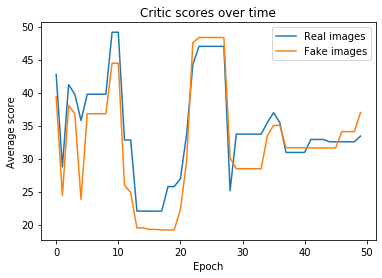

In [13]:
plot_validation(wgan_scores, 'Critic scores over time', 5)

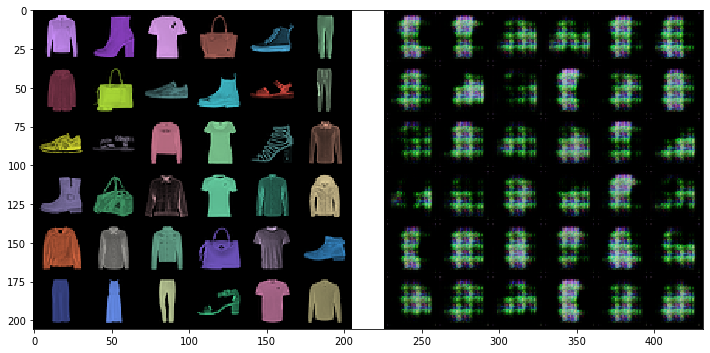

In [18]:
image = generate_sample(generator_2, sampler, width, device)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(to_pil_image(image))